# Mind the Gap: Metadata Completion for Wellcome Catalogue
```Bash
author Louis Larcher, Arthur Taieb and Cassio Manuguera
```

**Abstract**  
The Wellcome Collection is a vast and culturally diverse set of materials, ranging from medical and ethnographic objects, historical manuscripts, books and journals spanning dozens of cultures and over 50 languages. Its materials range from everyday items to rare documents and artworks, making it a rich resource for understanding health, culture and the human experience across time.

Yet despite the breadth and value of these holdings, many items suffer from missing or incomplete metadata—such as unknown dates, origins or creators—which limits how effectively they can be catalogued, searched or interpreted. Our project aims to address this challenge by developing machine-learning methods to predict or approximate these missing fields using available textual descriptions and, when possible, images. By providing archivists with reliable, data-driven estimates, we seek to help enrich the Wellcome Collection’s records and improve access to its diverse cultural heritage.



In [1]:
# IMPORT ALL THE NEEDED FILES AND LIBRARIES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import sys
from pathlib import Path
from IPython.display import display, HTML

from scripts.loading import *
from scripts.helpers import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

c:\Users\Surface\Desktop\EPFL\MASTER\MA1_2025_2026\ML\WellcomeML\ML_proj2\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Exploratory Data Analysis 

To start this project we will first load the data and perform some basic analysis 
to understand the data we are working with.

In [2]:
raw_dataset = load_wellcome_data(n_samples=100000)

Using existing file: C:\Users\Surface\Desktop\EPFL\MASTER\MA1_2025_2026\ML\WellcomeML\data\works.json.gz
Loading 100000 samples from works.json.gz...


Parsing JSON lines: 100%|██████████| 100000/100000 [00:16<00:00, 6226.64it/s]



✓ Loaded 100,000 works
✓ DataFrame shape: (100000, 45)

Missing values (count):
genre_ids                  100000
production_date_to         100000
production_date_from       100000
precededBy_title            99838
precededBy_id               99838
succeededBy_title           99836
succeededBy_id              99836
partOf_id                   99365
issn                        98249
alternativeTitles           94187
edition                     93747
lettering                   90729
referenceNumber             87362
production_function         86240
description                 85337
isbn                        82311
wellcome_library_number     81644
thumbnail_url               69123
partOf_title                65230
genres                      42400
production_agents           32710
availability_status         27918
subject_ids                 21621
subjects                    21621
production_places           20158
notes                       16229
note_types                  16229
p

We can see that a lot of fields are quite empty thus we will juste get rid of it and work with less fields. Arbitrarly we choose to take out the fields that have more than 80% of missing values, the only exception is the description field because it can really gives a lot of infromation when present.

In [9]:
threshold = 0.80
missing_pct = raw_dataset.isnull().sum() / len(raw_dataset)

# columns under the threshold
cols_to_keep = missing_pct[missing_pct <= threshold].index.tolist()

# we get rid of every column with more than treshold% of NaNs except description because of its relevance
if "description" in raw_dataset.columns and "description" not in cols_to_keep:
    cols_to_keep.append("description")

filtered = raw_dataset[cols_to_keep]


In [10]:
print(filtered.columns)

Index(['id', 'title', 'workType', 'workType_id', 'physicalDescription',
       'production_date', 'production_places', 'production_agents',
       'contributors', 'contributor_roles', 'contributor_ids', 'subjects',
       'subject_ids', 'genres', 'languages', 'language_ids', 'identifiers',
       'sierra_system_number', 'notes', 'note_types', 'thumbnail_url',
       'has_digitized_items', 'items_count', 'availability_status',
       'partOf_title', 'parts_count', 'holdings_count', 'images_count',
       'description'],
      dtype='object')



Our filtered dataset has: 29 columns and 100000 rows.


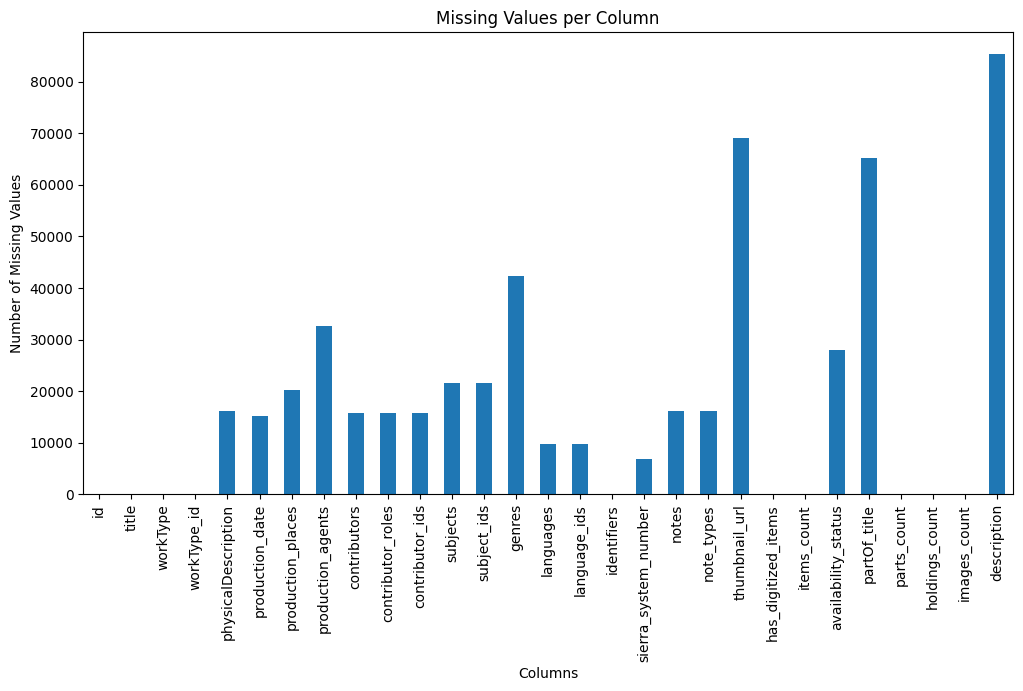


A random record from the dataframe:



,57177
id,vjs6hjmc
title,Albert Schweitzer : das Leben eines guten Menschen / mit einer Einführung von Robert Jungk und einem Epilog von Niko Kazantzakis.
workType,Books
workType_id,a
physicalDescription,"350 pages, 43 unnumbered pages of plates : illustrations, facsimiles, portraits ; 21 cm"
production_date,1955
production_places,[München]
production_agents,Kindler
contributors,"Jungk, Robert, 1913-1994."
contributor_roles,Unknown


In [11]:
# shape of the dataset
print(f"\nOur filtered dataset has: {filtered.shape[1]} columns and {filtered.shape[0]} rows.")

# how many missing values per column
missing_values = filtered.isnull().sum()

plt.figure(figsize=(12,6))
plt.title("Missing Values per Column")
missing_values.plot(kind='bar')
plt.ylabel("Number of Missing Values")
plt.xlabel("Columns")
plt.show();

print_one_random_record(filtered)

We have now a dataframe more or less filtered but we still have a lot of columns that make no sense to use for our task, for example the _identifiers_ or the _urls_. We will have to do some more __feature selection__.

In [12]:
# Remove non-predictable columns and with no corelation to the target
columns_to_remove = [
    # System IDs - just internal database identifiers, not predictable
    'id', 'workType_id', 'contributor_ids', 'subject_ids', 'language_ids', 
    'identifiers', 'sierra_system_number',
    
    # Counts - database metadata, not intrinsic properties of the work
    'items_count', 'parts_count', 'holdings_count', 'images_count',
    
    # Operational data - library-specific, not about the work itself
    'has_digitized_items', 'availability_status',
    
    # Less useful duplicates - keep the main version, remove auxiliary
    'note_types'  # Keep 'notes', remove the types since notes contain more info
]
necessary_df = filtered.copy().drop(columns=columns_to_remove);

# Display percentage of missing values per column with a custom styled table
null_pct = necessary_df.isnull().mean().sort_values(ascending=False) * 100
df_null = pd.DataFrame({
    "Column": null_pct.index,
    "% Null": [f"{v:.2f}%" for v in null_pct.values]
})

css = """
<style> 
.table-fixed {border-collapse: collapse; width: 70%; max-width: 900px;} 
.table-fixed th, 
.table-fixed td {border: 1px solid #ddd; padding: 6px 10px; text-align: left;} 
.table-fixed th {background:#808080; font-weight:600;} 
</style>
"""
display(HTML(css + df_null.to_html(index=False, classes="table-fixed", escape=False)))

Column,% Null
description,85.34%
thumbnail_url,69.12%
partOf_title,65.23%
genres,42.40%
production_agents,32.71%
subjects,21.62%
production_places,20.16%
notes,16.23%
physicalDescription,16.12%
contributor_roles,15.71%


In [13]:
print_one_random_record(necessary_df)


A random record from the dataframe:



,11688
title,"The English remedy, or, Talbor's wonderful secret for cureing of agues and feavers / sold by the author Sir Robert Talbor to the Most Christian King, and since his death ordered by His Majesty to be published in French for the benefit of his subjects ; and now translated into English for publick good."
workType,Books
physicalDescription,"5 unnumbered pages, 112 pages"
production_date,1682
production_places,London
production_agents,Printed by J. Wallis for Jos. Hindmarsh
contributors,"Blégny, Monsieur de (Nicolas), 1652-1722; Talbor, Robert, Sir, 1642-1681"
contributor_roles,Unknown; Unknown
subjects,Medicine - Early works to 1800
genres,Electronic books


__Our dataset only contains columns that interest us.__ 

# Preprocessing
We now have to __preprocess__ the data. The goal is to predict missing values in the dataset using the other fields as input so we will not have to fill NaNs. But we still have to deal with classic preprocessings such as categorical variables encoding, text vectorization and normalization.

We do not want to _infect_ our testing dataset with the training one. So we split them before any normalization.

In [14]:
train_test_ratio = 0.8
train = necessary_df.sample(frac = train_test_ratio, random_state= 42)
test = necessary_df.drop(train.index)
print(f"We decide to use {train_test_ratio*100}% of the data for the training.\n"
      f"Therefore we have a training sample of size {train.shape} and the test one of size {test.shape}")

We decide to use 80.0% of the data for the training.
Therefore we have a training sample of size (80000, 15) and the test one of size (20000, 15)


In [25]:
cumsum = train['production_places'].value_counts(normalize=True).cumsum()
print(f"We need the top {(cumsum <= 0.80).sum()} of the values to span 80% of all the production_places inside the dataset")
cumsum = train['languages'].value_counts(normalize=True).cumsum()
print(f"We need the top {(cumsum <= 0.95).sum()} of the values to span 95% of all the languages inside the dataset")

We need the top 545 of the values to span 80% of all the production_places inside the dataset
We need the top 15 of the values to span 95% of all the languages inside the dataset


## Data Preprocessing Strategy

Our preprocessing pipeline transforms raw textual and categorical data into numerical features for machine learning. We'll focus on **predicting production dates** as our primary task, using the other fields as input features.

### Column Usage

#### **Input Features** (used to make predictions):

**Text Features - Rich Information Sources:**
- **`title`**: Primary feature - most structured and consistently filled (0% missing). Contains publication names, dates, authors, and subjects.
- **`description`**: Detailed content descriptions when available (85% missing, but very informative when present).
- **`physicalDescription`**: Technical details (pages, dimensions, format) that correlate with time periods and work types.
- **`notes`**: Supplementary information including bibliographic references and historical context.
- **`partOf_title`**: Series/collection membership provides contextual information.

**Categorical Features:**
- **`workType`**: Type of work (Books, Journals, etc.) - strong signal for prediction patterns.

**Structured Features (when available):**
- **`production_places`**: Geographic origin - historical publishing centers indicate time periods.
- **`production_agents`**: Publishers/manufacturers - can indicate era through known active periods.
- **`contributors`**: Authors/creators - some may have known active periods.
- **`contributor_roles`**: Role information provides context about the work.
- **`subjects`**: Subject classifications - certain topics correlate with time periods.
- **`genres`**: Genre labels provide additional classification context.
- **`languages`**: Language can indicate geographic/temporal origin.

**Metadata:**
- **`thumbnail_url`**: Kept for potential future image-based modeling (multimodal approach).

#### **Target Variable** (what we predict):

- **`production_date`**: Our primary prediction target. We'll extract years and treat this as a **regression problem** (predicting numeric year values like 1928, 1845, etc.).

### Preprocessing Steps

1. **Text Vectorization (TF-IDF)**: Each text column vectorized separately to preserve field-specific importance
2. **Categorical Encoding**: One-hot encode `workType`
3. **Multi-value Fields**: Handle semicolon-separated values (contributors, subjects, etc.) appropriately
4. **Target Extraction**: Parse `production_date` to extract numeric years

### Why This Approach?

We treat this as a **supervised regression problem**: given rich metadata about a work, predict when it was produced. The diverse text and categorical features provide complementary signals that, when combined, can estimate publication dates even when explicit date information is missing.
This is our first objective we will later on try to estimate other value like the language.

### Text Vectorization with TF-IDF

Machine learning models require numerical inputs. We use **TF-IDF (Term Frequency-Inverse Document Frequency)** to convert text into numerical vectors by assigning higher weights to rare, distinctive words (e.g., "penicillin", "1928") and lower weights to common words (e.g., "the", "and").

**Why vectorize separately?**

We vectorize each text column independently (`title`, `description`, `notes`, `physicalDescription`, `partOf_title`) so the model learns that words carry different importance depending on context. For example, "1928" in a title is more reliable than in notes.

All vectorizers are **fitted only on training data** to prevent information leakage.


In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Define text columns to vectorize
text_columns = ['title', 'description', 'notes', 'physicalDescription', 'partOf_title']

# Store vectorizers and transformed data
vectorizers = {}
train_vectors = {}
test_vectors = {}

for col in text_columns:
    print(f"\nVectorizing '{col}'...")
    
    # Fill NaN with empty string (TF-IDF can't handle NaN)
    train_text = train[col].fillna('')
    test_text = test[col].fillna('')
    
    # Create and fit vectorizer on training data only
    vectorizer = TfidfVectorizer(
        max_features=1000,  # Keep top 1000 words (adjust based on column)
        ngram_range=(1, 2),  # Use both single words and two-word phrases
        min_df=2,  # Ignore words appearing in fewer than 2 documents
        max_df=0.95  # Ignore words appearing in >95% of documents
    )
    
    # Fit on train, transform both
    train_vectors[col] = vectorizer.fit_transform(train_text)
    test_vectors[col] = vectorizer.transform(test_text)
    vectorizers[col] = vectorizer
    
    print(f"  Shape: {train_vectors[col].shape}")
    print(f"  Non-zero entries: {train_vectors[col].nnz}")

# Check total features
total_features = sum(v.shape[1] for v in train_vectors.values())
print(f"\n✓ Total TF-IDF features: {total_features:,}")


Vectorizing 'title'...
  Shape: (80000, 1000)
  Non-zero entries: 572722

Vectorizing 'description'...
  Shape: (80000, 1000)
  Non-zero entries: 283098

Vectorizing 'notes'...
  Shape: (80000, 1000)
  Non-zero entries: 1286620

Vectorizing 'physicalDescription'...
  Shape: (80000, 1000)
  Non-zero entries: 539483

Vectorizing 'partOf_title'...
  Shape: (80000, 1000)
  Non-zero entries: 186536

✓ Total TF-IDF features: 5,000


**Test relevance**

In [33]:
# Example: See most important words in 'title' for predicting dates
from scipy.sparse import hstack
from sklearn.linear_model import Ridge
import re
from sklearn.metrics import mean_absolute_error


def extract_year(date_str):
    """Extract first 4-digit year from production_date string"""
    if pd.isna(date_str):
        return None
    match = re.search(r'\b(\d{4})\b', str(date_str))
    return int(match.group(1)) if match else None

# Concatenate all text features
X_train_text = hstack([train_vectors[col] for col in text_columns])
X_test_text = hstack([test_vectors[col] for col in text_columns])

# Create year column first
train['year'] = train['production_date'].apply(extract_year)
test['year'] = test['production_date'].apply(extract_year)

# Filter rows with valid years (convert to numpy array)
train_valid_mask = train['year'].notna().values  # Added .values
X_train_subset = X_train_text[train_valid_mask]
y_train = train.loc[train['year'].notna(), 'year']

# Now train
model = Ridge()
model.fit(X_train_subset, y_train)

print(f"Training samples: {len(y_train):,}")
print(f"Training R²: {model.score(X_train_subset, y_train):.3f}")

# Test on test set
test_valid_mask = test['year'].notna().values  # Added .values
X_test_subset = X_test_text[test_valid_mask]
y_test = test.loc[test['year'].notna(), 'year']

y_pred = model.predict(X_test_subset)
mae = mean_absolute_error(y_test, y_pred)

print(f"\nTest samples: {len(y_test):,}")
print(f"Test R²: {model.score(X_test_subset, y_test):.3f}")
print(f"Mean Absolute Error: {mae:.1f} years")

Training samples: 67,410
Training R²: 0.795

Test samples: 16,826
Test R²: 0.772
Mean Absolute Error: 27.0 years
